In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import scipy
from sklearn.multioutput import MultiOutputRegressor
from scipy.io import loadmat
import ast
from sklearn.decomposition import PCA
from toolz.curried import unique
import seaborn as sns
import matplotlib.pyplot as plt
from utils.helpers import select_descriptors, read_embeddings
from sklearn.neural_network import MLPRegressor
from torch.utils.data import dataset
from statannotations.Annotator import Annotator


In [2]:
def custom_ridge_regression(X, y):
    linreg = RidgeCV()
    linreg = MultiOutputRegressor(linreg,n_jobs=-1)
    estimator = linreg.fit(X, y)
    return estimator

In [3]:
def custom_MLP_regression(X, y):
    linreg = MLPRegressor(hidden_layer_sizes=(4,8,16),max_iter=1000,activation='relu',solver='adam',random_state=seed,early_stopping=True)
    estimator = linreg.fit(X, y)
    print(len(estimator.loss_curve_))
    print("MLP")
    return estimator

In [71]:
#define an MLP pytorch model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
class MLPRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc_final = nn.Linear(hidden_size // 4, output_size)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        # x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        # x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = torch.tanh(self.fc_final(x))  # Restrict output to [-1, 1]
        return x
    def predict(self,x):
        return self.forward(x)

In [50]:
#write a MLP regression function with pytorch
def custom_MLP_regression_pytorch(X, y):
    #define the model
    model = MLPRegression(input_size=X.shape[1], hidden_size=512, output_size=y.shape[1])
    #train-validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=seed)

    #define the loss function
    criterion = nn.MSELoss()
    losses = []
    losses_val = []

    #define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    # decayRate = 0.96
    # my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

    # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    #train the model
    best_loss = 1000
    patience = 30
    dataset = TensorDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)


    for epoch in range(1000):
        model.train()
        for X,y in data_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs,y )
            loss.backward()
            # optimizer.step()
            optimizer.step()
            losses.append(loss.item())

            #early stopping with validation loss
        model.eval()
        with torch.no_grad():
            # y_val = torch.tensor(torch.zeros((y_val.shape[0],y_val.shape[1])))
            loss_val = criterion(model(X_val),y_val)
            print(f"Epoch {epoch}, Loss {loss.item()}, Validation Loss {loss_val.item()}")
            if best_loss - loss_val.item() < 0:
                patience -= 1

            else:
                patience = 30
                best_loss  = loss_val.item()
                best_model = model
            if patience == 0:
                break


            losses_val.append(loss_val.item())
        scheduler.step(loss_val)
        # loss_prev = loss.item()
        #early stopping with patience of 10
        # if loss_prev - loss.item() < 0.0001:
        #     patience -= 1
        #     if patience == 0:
        #         break
        # else:
        #     patience = 100
    #plot loss
        # plt.plot(losses)
    plt.plot(losses_val)

    #return the model
    return best_model

In [6]:
def metrics_per_descriptor(X, y, linreg):
 
    """
    Calculate predictions, mean squared errors, and Pearson correlations for each descriptor.

    Parameters:
    X (array-like): Input features.
    y (array-like): True target values.
    linreg (object): Linear regression model with a predict method.

    Returns:
    tuple: A tuple containing predicted values, a list of MSEs, and a list of correlations.
    """
    predicted = linreg.predict(X)
    if type(predicted) == torch.Tensor:
        predicted = predicted.detach().numpy()
        y = y.detach().numpy()
    
    # Ensure y is 2D for consistent iteration
    y = y if len(y.shape) > 1 else y.reshape(-1, 1)
    predicted = predicted if len(predicted.shape) > 1 else predicted.reshape(-1, 1)
    
    

    mse_errors = [mean_squared_error(predicted[:, i], y[:, i]) for i in range(y.shape[1])]
    correlations = [scipy.stats.pearsonr(predicted[:, i], y[:, i]) for i in range(y.shape[1])]
    spearman_correlations = [scipy.stats.spearmanr(predicted[:, i], y[:, i]) for i in range(y.shape[1])]
    return predicted,y, mse_errors, correlations,spearman_correlations

In [7]:
def train_and_eval_ntimes(X,y, times,n_components=None,model='linear_regression'):
    """
    Train and evaluate a regression model using cross-validation.

    Parameters:
    data (DataFrame): Input data containing embeddings and fmri_average.
    times (int): Number of cross-validation iterations.
    n_components (int, optional): Number of components for dimensionality reduction.

    Returns:
    tuple: Contains CIDs, predicted values, test targets, runs, MSE errors, and correlations.
    """
    mse_errors_crossvalidated = []
    correlations_crossvalidated = []
    spearman_crossvalidated = []
    predicteds = []
    y_tests = []
    runs_predictions = []
    runs_metrics = []
    voxels = []
    voxels_predicteds = []
    for i in range(times):
        print(f"Processing run {i}")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed + i
        )
        if n_components:
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            
        if model == 'linear_regression':
            linreg = custom_ridge_regression(X_train, y_train)
        elif model=='MLP':
            linreg = custom_MLP_regression(X_train, y_train)
        elif model=='MLP_pytorch':
            X_train = torch.tensor(X_train).float()
            y_train = torch.tensor(y_train).float()
            X_test = torch.tensor(X_test).float()
            y_test = torch.tensor(y_test).float()

            linreg = custom_MLP_regression_pytorch(X_train, y_train)


        predicted,y_test, mse_errors, correlations,spearman_correlation = metrics_per_descriptor(X_test, y_test, linreg)
        print(y_test.shape,"y")
        print(predicted.shape,"predicted")


        #flatten the predicted and y_test arrays
        voxels_predicted = np.arange(predicted.shape[1])
        predicted = np.concatenate(predicted)
        y_test_flatten = np.concatenate(y_test)
        print(y_test_flatten)
        mse_errors_crossvalidated.extend(mse_errors)
        correlations_crossvalidated.extend(correlations)
        spearman_crossvalidated.extend(spearman_correlation)
        predicteds.extend(predicted)
        y_tests.extend(y_test_flatten)
        
        runs_metrics.extend([i] * y_test.shape[1])
        runs_predictions.extend([i] * y_test.shape[0]*y_test.shape[1])
        
        voxels.extend(np.arange(y.shape[1]))
        
        voxels_predicted = np.repeat(voxels_predicted,y_test.shape[0])
        voxels_predicteds.extend(voxels_predicted)

    return predicteds, y_tests, runs_metrics,runs_predictions, mse_errors_crossvalidated, correlations_crossvalidated,spearman_crossvalidated,voxels,voxels_predicteds

In [8]:
def pipeline(X,y, times=30,n_components=None,model='linear_regression'):
    """
    Run the pipeline for a specific voxel and model, processing fMRI and embeddings data.

    Parameters:
    fmri_ev (DataFrame): fMRI event data.
    voxel (int): The voxel identifier.
    model_name (str): Name of the model being evaluated.
    input_file (str): Path to the input CSV file.
    times (int, optional): Number of cross-validation iterations. Default is 30.
    n_components (int, optional): Number of components for dimensionality reduction. Default is None.

    Returns:
    tuple: DataFrames containing predictions and metrics.
    """
    # Filter voxel-specific data
    
    

    # Train and evaluate the model
    results = train_and_eval_ntimes(X,y, times=times,n_components=n_components,model=model)
    predicteds, y_tests, runs_metrics,runs_predictions, mse_errors, correlations,spearman_correlations,targets,targets_predicteds = results
    predicteds = np.asarray(predicteds)
    y_tests = np.asarray(y_tests)
   
    runs_metrics = np.asarray(runs_metrics)
    runs_predictions = np.asarray(runs_predictions)
    mse_errors = np.asarray(mse_errors)
    correlations = np.asarray(correlations)
    spearman_correlations = np.asarray(spearman_correlations)
    targets = np.asarray(targets)
    targets_predicteds = np.asarray(targets_predicteds)

    mse_errors = np.asarray(mse_errors)
    correlations = np.asarray(correlations)

    
    stats_correlations = correlations[:, 0]
    pvalues_correlations = correlations[:, 1]
    
    stats_spearman_correlations = spearman_correlations[:, 0]
    pvalues_spearman_correlations = spearman_correlations[:, 1]
    


    metrics_df = pd.DataFrame(
        np.column_stack([stats_correlations, pvalues_correlations, mse_errors,targets,stats_spearman_correlations,pvalues_spearman_correlations,runs_metrics]),
        columns=['pearson_correlation', 'pearson_pvalue', 'mse','voxel','spearman_correlation','spearman_pvalue','run']
    )
    
    predictions_df = pd.DataFrame(
        np.column_stack([predicteds, y_tests,targets_predicteds,runs_predictions]),
        columns=['predicted', 'target', 'voxel','run']
    )

    return predictions_df, metrics_df

In [9]:
def compute_correlation(X,y,n_components=None,model='linear_regression',times=30):
    """
    Compute correlations for MolFormer across specified layers and voxels.

    Parameters:
    times (int): Number of cross-validation iterations.
    n_components (int): Number of components for dimensionality reduction.
    fmri_ev (DataFrame): fMRI event data.
    input_file_molformer (str): Base path for MolFormer input files.
    layers (list, optional): List of layers to process. Default is [13].

    Returns:
    tuple: Metrics and predictions for MolFormer.
    """

    df_predictions_molformer, df_metric_molformer = pipeline(X,
        y, times=times,n_components=n_components,model=model)

    df_metric_molformer["subject"]=subject
    df_predictions_molformer["subject"]=subject

    return df_predictions_molformer, df_metric_molformer


# Load embeddings

In [10]:


#define all these parameters
i = 1000
dataset_name = 'sagarfmri'
data_type = 'representation'
representation_name = 'fmri'
batch_size = 160
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'AMY'
subject = 1


# Regression for Sagar or Keller dataset

## X is defined as embeeddigns and y can be either Continues behavioral ratings or dragon features

<Axes: ylabel='Count'>

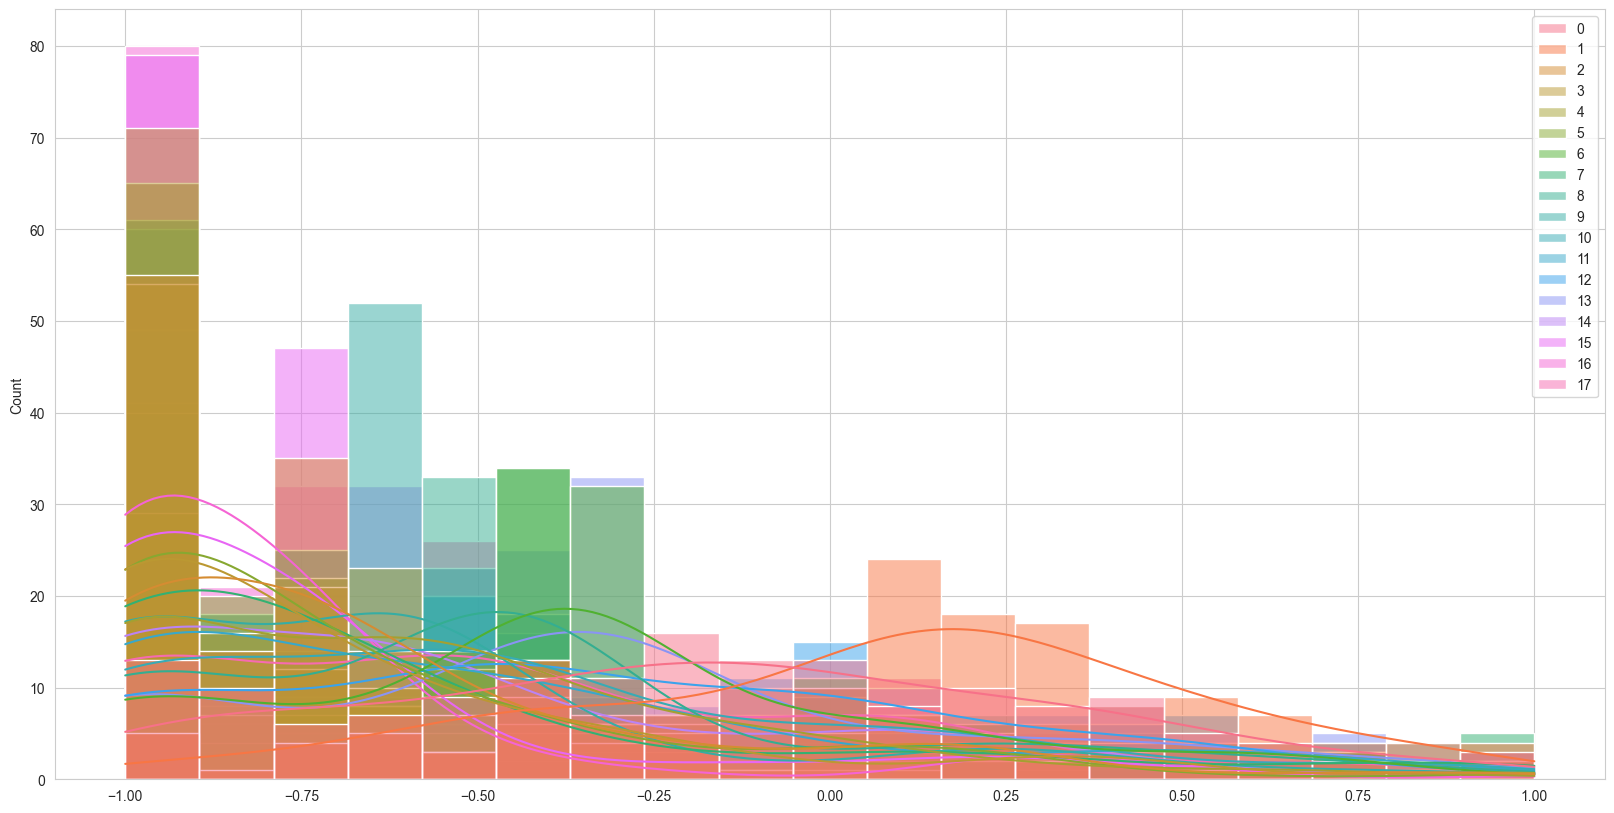

In [73]:
y_type = 'ratings'
# y_type = 'dragon_features'
dataset = 'sagar'
# dataset = 'keller'
if y_type not in ['ratings','dragon_features']:
    raise ValueError("y_type must be either 'ratings' or 'dragon_features'")
if dataset not in ['sagar','keller']:
    raise ValueError("dataset must be either 'sagar' or 'keller'")
y = np.load(f'data/{dataset}/{y_type}_{subject}.npy')
# y= (y - np.mean(y))/np.std(y)
fig,ax= plt.subplots(figsize=(20,10))
sns.histplot(y,ax=ax,kde=True)

In [72]:
df_metrics_all = pd.DataFrame()
for roi in ['AMY','OFC','PirF','PirT']:
    X=np.load(f"data/subject1/fMRI/{roi}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
    df_predictions, df_metric = compute_correlation(X,y,n_components=None,model='linear_regression')

    df_metric['roi'] = roi
    X_random = np.random.rand(X.shape[0],X.shape[1])
    df_predictions_random , df_metric_random = compute_correlation(X_random,y,n_components=None)

    df_metric_random['roi'] = roi+'_random'
    df_metrics_all = pd.concat([df_metrics_all,df_metric_random])
    df_metrics_all = pd.concat([df_metrics_all,df_metric])

Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing run 29
Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing r

KeyboardInterrupt: 

In [12]:
#define all these parameters
i = 1000
dataset_name = 'sagar'
data_type = 'representation'
representation_name = 'molformer'
batch_size = 160
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'None'
subject = 1
X=np.load(f"data/subject1/{representation_name}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
base_dir = 'data/'
input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        # embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
        #                                      grand_avg=True if dataset_name == 'keller' else False)
embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
                                             grand_avg=True if dataset_name == 'keller' or dataset_name=='sagar' else False)
CIDs_1 = pd.read_csv(f'data/{dataset}/CIDs_smiles_{subject}.csv')
indices = np.where( np.isin(CIDs.cpu().numpy(), CIDs_1['CIDs'].values))[0]
X = X[indices]
df_predictions, df_metric = compute_correlation(X,y,n_components=None)#gran
df_metric['roi'] = 'MolFormer'
df_metrics_all = pd.concat([df_metrics_all,df_metric])


Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing run 29


In [11]:
# i = 1000
# dataset_name = 'sagar'
# data_type = 'representation'
# representation_name = 'pom'
# batch_size = 195
# lr = 0.1
# seed = 1
# model_name = 'contrastive'
# latent_dist_fun = 'poincare'
# distance_method = 'euclidean'
# temperature = 0.1
# n_neighbors = 20
# epsilon = 10.0
# roi = 'None'
# subject = 1
# X=np.load(f"data/subject1/{representation_name}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
# base_dir = 'data/'
# input_embeddings = f'embeddings/molformer/{dataset_name}_molformer_embeddings_13_Apr17.csv'
#         # embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
#         #                                      grand_avg=True if dataset_name == 'keller' else False)
# embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
#                                              grand_avg=True if dataset_name == 'keller' or dataset_name=='sagar' else False)
# CIDs_1 = pd.read_csv(f'data/{dataset}/CIDs_smiles_{subject}.csv')
# indices = np.where( np.isin(CIDs.cpu().numpy(), CIDs_1['CIDs'].values))[0]
# X = X[indices]
# df_predictions, df_metric = compute_correlation(X,y,n_components=None)#gran
# df_metric['roi'] = 'POM'
# df_metrics_all = pd.concat([df_metrics_all,df_metric])

Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing run 29


In [12]:
fig,ax= plt.subplots(figsize=(20,10))
sns.histplot(data=df_metrics_all,x='pearson_correlation',hue='roi',ax=ax,kde=True)

<Axes: xlabel='pearson_correlation', ylabel='Count'>

<Axes: xlabel='roi', ylabel='mse'>

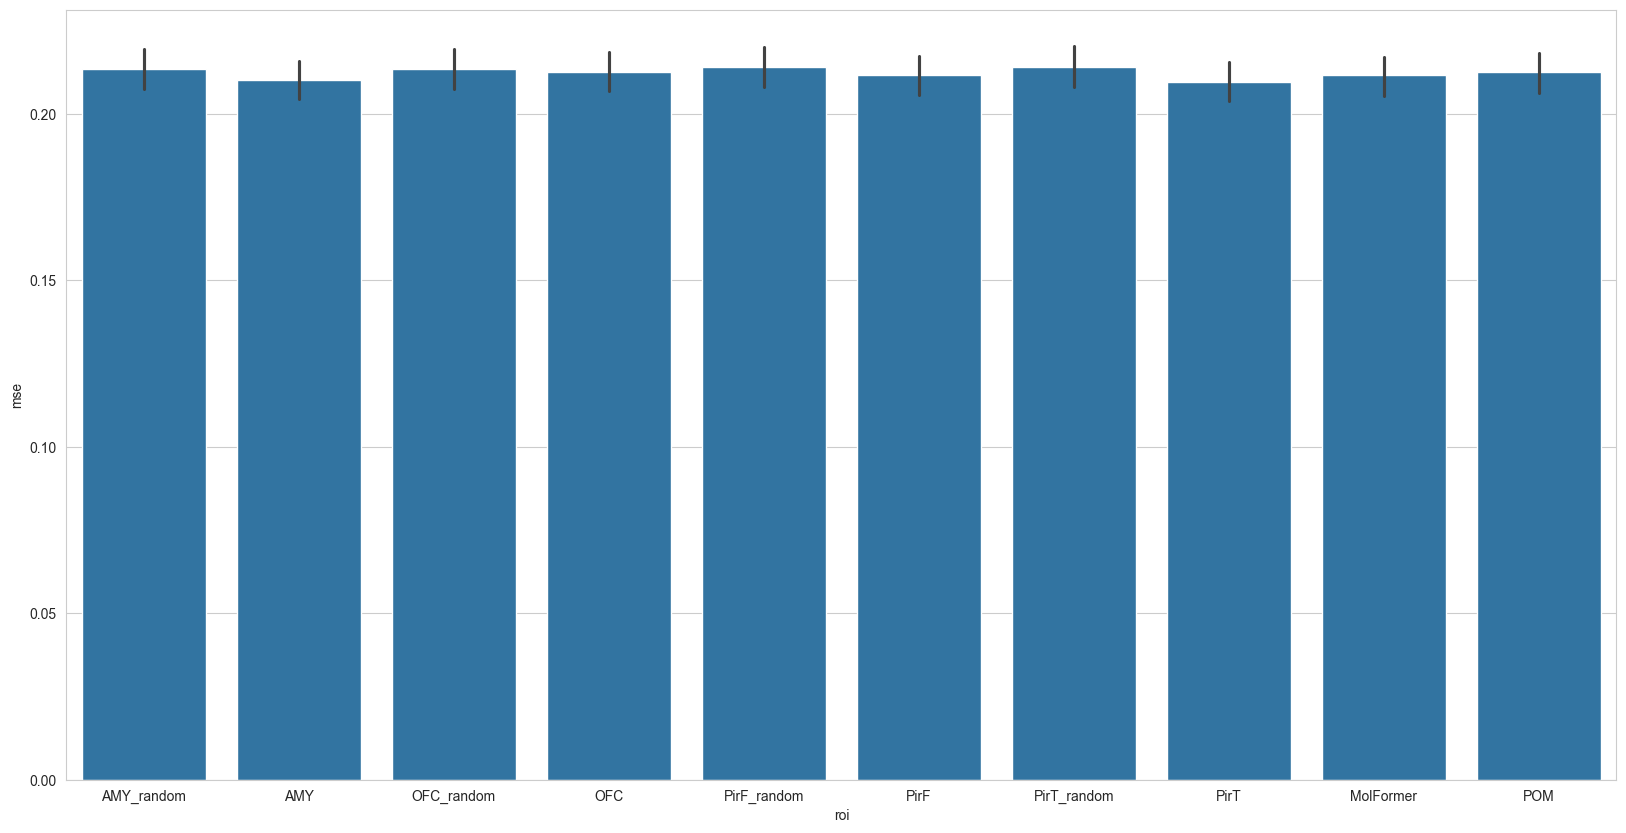

In [13]:
fig,ax= plt.subplots(figsize=(20,10))
sns.barplot(data=df_metrics_all,x='roi',y='mse',ax=ax)

#

<Axes: xlabel='roi', ylabel='pearson_correlation'>

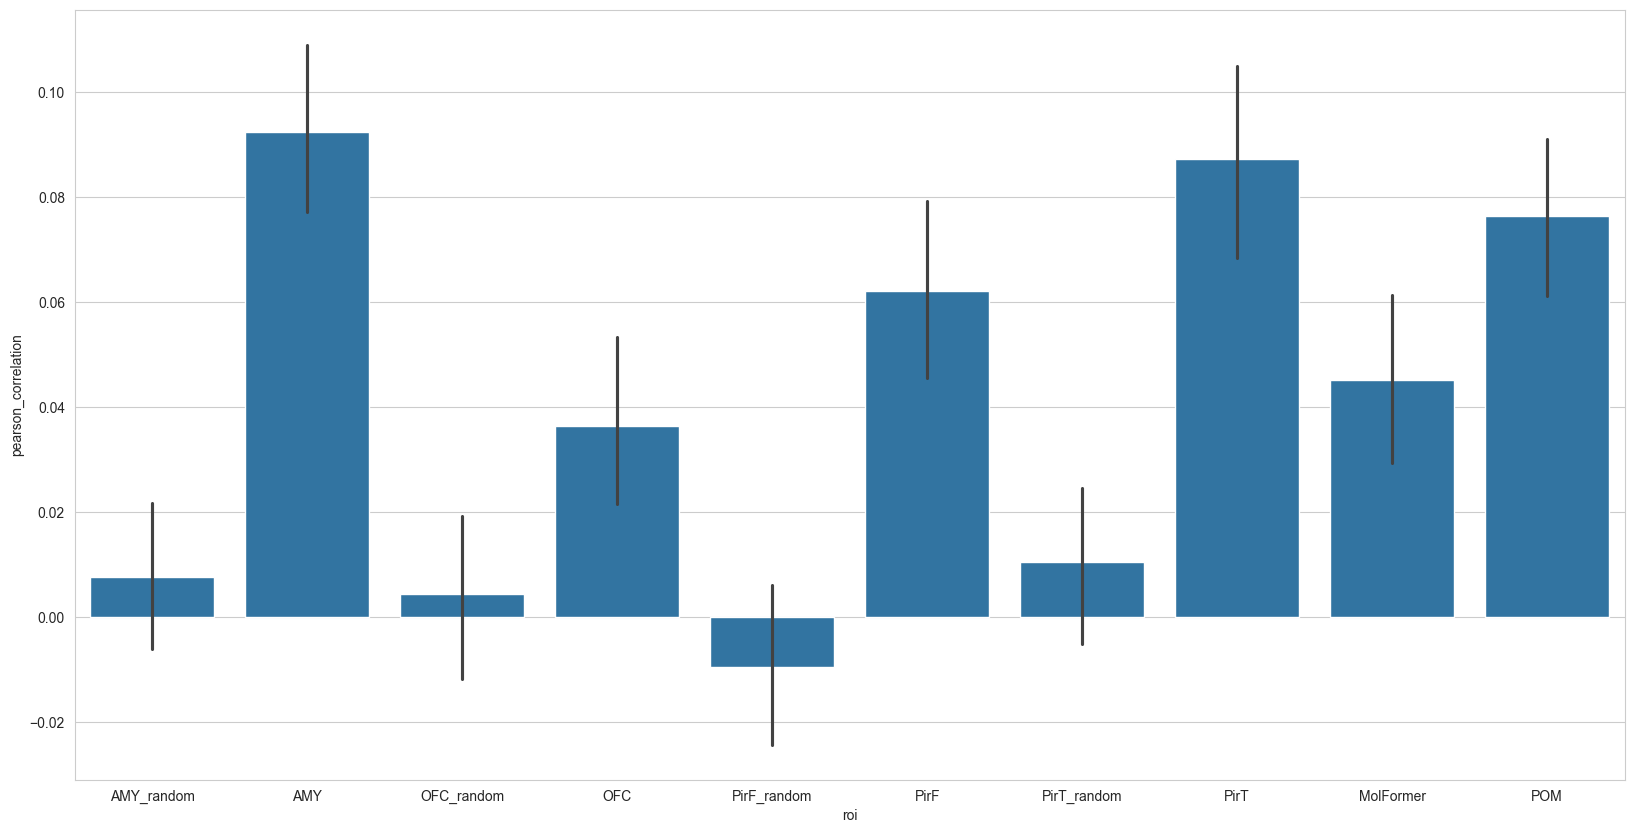

In [14]:
fig,ax= plt.subplots(figsize=(20,10))
sns.barplot(data=df_metrics_all,x='roi',y='pearson_correlation',ax=ax)

In [10]:
import warnings
warnings.filterwarnings("ignore", message="The verbose parameter is deprecated. Please use get_last_lr()")


In [19]:
# Get the min and max for each column
min_values = np.min(y, axis=0)
max_values = np.max(y, axis=0)

In [21]:
max_values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

## MLP

Processing run 0
Epoch 0, Loss 0.5029221177101135, Validation Loss 0.47553011775016785
Epoch 1, Loss 0.4622381627559662, Validation Loss 0.4511805474758148
Epoch 2, Loss 0.4353750944137573, Validation Loss 0.4259573817253113
Epoch 3, Loss 0.40952956676483154, Validation Loss 0.39928412437438965
Epoch 4, Loss 0.3789674639701843, Validation Loss 0.37158331274986267
Epoch 5, Loss 0.35524025559425354, Validation Loss 0.34302136301994324
Epoch 6, Loss 0.32844847440719604, Validation Loss 0.31413671374320984
Epoch 7, Loss 0.3131106197834015, Validation Loss 0.2861574590206146
Epoch 8, Loss 0.2840045988559723, Validation Loss 0.26072660088539124
Epoch 9, Loss 0.22626285254955292, Validation Loss 0.2381294071674347
Epoch 10, Loss 0.2589753270149231, Validation Loss 0.22012172639369965
Epoch 11, Loss 0.23384134471416473, Validation Loss 0.20754480361938477
Epoch 12, Loss 0.20595043897628784, Validation Loss 0.20001398026943207
Epoch 13, Loss 0.19976556301116943, Validation Loss 0.19600364565849

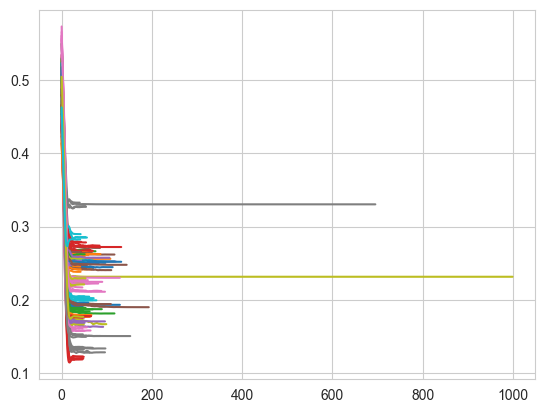

In [65]:
y_type = 'ratings'
# y_type = 'dragon_features'
dataset = 'sagar'
# dataset = 'keller'
i = 1000
dataset_name = 'sagarfmri'
data_type = 'representation'
representation_name = 'fmri'
batch_size = 160
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
subject = 1
if y_type not in ['ratings','dragon_features']:
    raise ValueError("y_type must be either 'ratings' or 'dragon_features'")
if dataset not in ['sagar','keller']:
    raise ValueError("dataset must be either 'sagar' or 'keller'")
y = np.load(f'data/{dataset}/{y_type}_{subject}.npy')


df_metrics_all = pd.DataFrame()
#z-score y
# y = np.load(f'data/{dataset}/ratings_{subject}.npy')



for roi in ['AMY','OFC','PirF','PirT']:
    X=np.load(f"data/subject1/fMRI/{roi}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
    df_predictions, df_metric = compute_correlation(X,y,n_components=None,model='MLP_pytorch',times=10)
    #
    df_metric['roi'] = roi
    df_metric['nrmse'] = (np.sqrt(df_metric['mse'])+1)/(2)




    X_random =  np.random.rand(X.shape[0],X.shape[1])
    # print(X.shape,y.shape)
    df_predictions_random , df_metric_random = compute_correlation(X_random,y,n_components=None,model='MLP_pytorch',times=30)

    df_metric_random['roi'] = roi+'_random'
    df_metric_random['nrmse'] = (np.sqrt(df_metric_random['mse'])+1)/(2)
    # df_metric_random['rmse_normalized'] = df_metric_random['rmse']/(df_metric_random['max_fmri']-df_metric_random['min_fmri'])
    df_metrics_all = pd.concat([df_metrics_all,df_metric_random])
    df_metrics_all = pd.concat([df_metrics_all,df_metric])

Processing run 0
Epoch 0, Loss 0.5253289937973022, Validation Loss 0.49343323707580566
Epoch 1, Loss 0.4518094062805176, Validation Loss 0.4762643575668335
Epoch 2, Loss 0.47053176164627075, Validation Loss 0.4587661325931549
Epoch 3, Loss 0.4772588610649109, Validation Loss 0.4401589035987854
Epoch 4, Loss 0.4648275673389435, Validation Loss 0.41936665773391724
Epoch 5, Loss 0.39248037338256836, Validation Loss 0.39587873220443726
Epoch 6, Loss 0.3679518699645996, Validation Loss 0.3700311779975891
Epoch 7, Loss 0.34513065218925476, Validation Loss 0.3425246775150299
Epoch 8, Loss 0.30593571066856384, Validation Loss 0.3144429326057434
Epoch 9, Loss 0.28265082836151123, Validation Loss 0.28698983788490295
Epoch 10, Loss 0.2690529525279999, Validation Loss 0.2622220814228058
Epoch 11, Loss 0.268797367811203, Validation Loss 0.2411968857049942
Epoch 12, Loss 0.276074081659317, Validation Loss 0.22486361861228943
Epoch 13, Loss 0.24482470750808716, Validation Loss 0.2133803367614746
Epoc

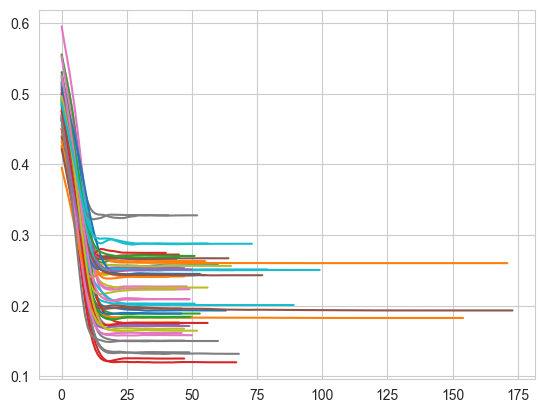

In [66]:
#define all these parameters
i = 1000
dataset_name = 'sagar'
data_type = 'representation'
representation_name = 'molformer'
batch_size = 160
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'None'
subject = 1
X=np.load(f"data/subject1/{representation_name}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
base_dir = 'data/'
input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        # embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
        #                                      grand_avg=True if dataset_name == 'keller' else False)
embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
                                             grand_avg=True if dataset_name == 'keller' or dataset_name=='sagar' else False)
CIDs_1 = pd.read_csv(f'data/{dataset}/CIDs_smiles_{subject}.csv')
indices = np.where( np.isin(CIDs.cpu().numpy(), CIDs_1['CIDs'].values))[0]
X = X[indices]
df_predictions, df_metric = compute_correlation(X,y,n_components=None,model='MLP_pytorch',times=30)#gran
df_metric['roi'] = 'MolFormer'
df_metric['nrmse'] = (np.sqrt(df_metric['mse'])+1)/(2)

df_metrics_all = pd.concat([df_metrics_all,df_metric])

X_random = np.random.rand(X.shape[0],X.shape[1])
df_predictions, df_metric = compute_correlation(X_random,y,n_components=None,model='MLP_pytorch',times=30)#gran
df_metric['roi'] = 'MolFormer_random'
df_metric['nrmse'] = (np.sqrt(df_metric['mse'])+1)/(2)

df_metrics_all = pd.concat([df_metrics_all,df_metric])

Processing run 0
Epoch 0, Loss 0.5222397446632385, Validation Loss 0.4654688835144043
Epoch 1, Loss 0.42576876282691956, Validation Loss 0.4499247968196869
Epoch 2, Loss 0.4771016836166382, Validation Loss 0.4339965879917145
Epoch 3, Loss 0.4441741108894348, Validation Loss 0.4168796241283417
Epoch 4, Loss 0.44319963455200195, Validation Loss 0.39805668592453003
Epoch 5, Loss 0.43424493074417114, Validation Loss 0.3770098090171814
Epoch 6, Loss 0.3641379177570343, Validation Loss 0.35345950722694397
Epoch 7, Loss 0.36014002561569214, Validation Loss 0.32795363664627075
Epoch 8, Loss 0.3282039761543274, Validation Loss 0.30160433053970337
Epoch 9, Loss 0.2924347221851349, Validation Loss 0.2752625346183777
Epoch 10, Loss 0.29155755043029785, Validation Loss 0.25058478116989136
Epoch 11, Loss 0.26458463072776794, Validation Loss 0.22915789484977722
Epoch 12, Loss 0.2266683280467987, Validation Loss 0.21259234845638275
Epoch 13, Loss 0.2696332633495331, Validation Loss 0.2011382132768631


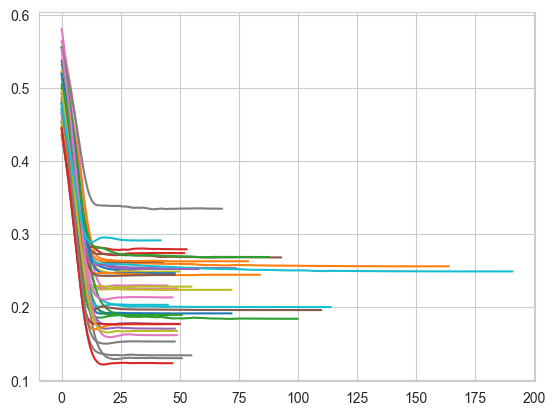

In [67]:
i = 1000
dataset_name = 'sagar'
data_type = 'representation'
representation_name = 'pom'
batch_size = 195
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'None'
subject = 1
X=np.load(f"data/subject1/{representation_name}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
base_dir = 'data/'
input_embeddings = f'embeddings/molformer/{dataset_name}_molformer_embeddings_13_Apr17.csv'
        # embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
        #                                      grand_avg=True if dataset_name == 'keller' else False)
embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
                                             grand_avg=True if dataset_name == 'keller' or dataset_name=='sagar' else False)
CIDs_1 = pd.read_csv(f'data/{dataset}/CIDs_smiles_{subject}.csv')
indices = np.where( np.isin(CIDs.cpu().numpy(), CIDs_1['CIDs'].values))[0]
X = X[indices]
df_predictions, df_metric = compute_correlation(X,y,n_components=None,model='MLP_pytorch',times=10)#gran
df_metric['roi'] = 'POM'
df_metric['nrmse'] = (np.sqrt(df_metric['mse'])+1)/(2)

df_metrics_all = pd.concat([df_metrics_all,df_metric])


X_random = np.random.rand(X.shape[0],X.shape[1])
df_predictions, df_metric = compute_correlation(X_random,y,n_components=None,model='MLP_pytorch',times=30)#gran
df_metric['roi'] = 'POM_random'
df_metric['nrmse'] = (np.sqrt(df_metric['mse'])+1)/(2)

df_metrics_all = pd.concat([df_metrics_all,df_metric])

In [19]:
df_metrics_all_avg_voxel = df_metrics_all.groupby(['voxel','roi']).mean(numeric_only=True).reset_index()

In [30]:
df_metrics_all['nrmse'] =  (np.sqrt(df_metrics_all['mse']))/(2)

In [22]:
df_metrics_all_avg_voxel_roi

pearson_correlation  pearson_pvalue       mse  voxel  \
0               0.226379        0.212803  0.279292    0.0   
1               0.310519        0.083680  0.117662    1.0   
2               0.088091        0.631635  0.156680    2.0   
3              -0.255127        0.158763  0.286728    3.0   
4               0.169494        0.353723  0.179897    4.0   
..                   ...             ...       ...    ...   
535             0.236835        0.191860  0.223389   13.0   
536            -0.143643        0.432854  0.202173   14.0   
537             0.125106        0.495087  0.102421   15.0   
538            -0.115272        0.529851  0.191962   16.0   
539            -0.173585        0.342052  0.216383   17.0   

     spearman_correlation  spearman_pvalue   run  subject         roi  rmse  
0                0.135643         0.459169   0.0        1         POM   NaN  
1                0.200568         0.271037   0.0        1         POM   NaN  
2                0.140647         0.442608   0.0        1         POM   NaN  
3               -0.318557         0.075575   0.0        1         POM   NaN  
4                0.230185         0.205006   0.0        1         POM   NaN  
..                    ...              ...   ...      ...         ...   ...  
535              0.258157         0.153704  29.0        1  POM_random   NaN  
536             -0.224461         0.216808  29.0        1  POM_random   NaN  
537              0.076632         0.676777  29.0        1  POM_random   NaN  
538             -0.073331         0.689998  29.0        1  POM_random   NaN  
539             -0.260344         0.150125  29.0        1  POM_random   NaN  

[720 rows x 10 columns]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_AMY_random vs. 9.0_AMY: t-test independent samples, P_val:7.418e-01 t=-3.318e-01
10.0_AMY_random vs. 10.0_AMY: t-test independent samples, P_val:8.109e-04 t=-3.639e+00
11.0_AMY_random vs. 11.0_AMY: t-test independent samples, P_val:6.134e-01 t=5.095e-01
12.0_AMY_random vs. 12.0_AMY: t-test independent samples, P_val:6.337e-01 t=4.804e-01
13.0_AMY_random vs. 13.0_AMY: t-test independent samples, P_val:1.045e-01 t=-1.663e+00
14.0_AMY_random vs. 14.0_AMY: t-test independent samples, P_val:3.603e-02 t=2.174e+00
15.0_AMY_random vs. 15.0_AMY: t-test independent samples, P_val:2.778e-01 t=-1.101e+00
16.0_AMY_random vs. 16.0_AMY: t-test independent samples, P_val:2.385e-01 t=1.198e+00
17.0_AMY_random vs. 17.0_AMY: t-test independent samples, P_val:6.346e-02 t=-1.912e+00
8.0_AMY_random vs. 8.0_AMY: t-t

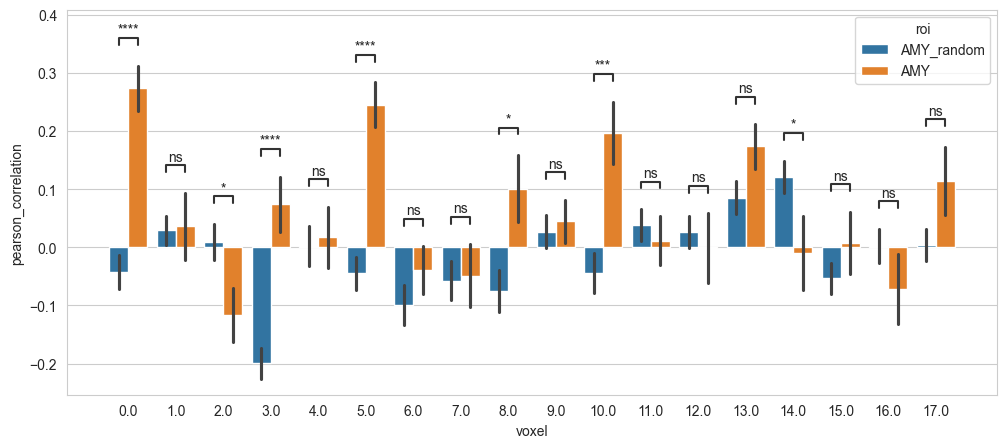

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_OFC_random vs. 9.0_OFC: t-test independent samples, P_val:1.375e-01 t=1.517e+00
10.0_OFC_random vs. 10.0_OFC: t-test independent samples, P_val:3.048e-01 t=1.040e+00
11.0_OFC_random vs. 11.0_OFC: t-test independent samples, P_val:2.960e-01 t=1.060e+00
12.0_OFC_random vs. 12.0_OFC: t-test independent samples, P_val:8.042e-03 t=2.797e+00
13.0_OFC_random vs. 13.0_OFC: t-test independent samples, P_val:1.567e-01 t=1.445e+00
14.0_OFC_random vs. 14.0_OFC: t-test independent samples, P_val:2.472e-03 t=3.242e+00
15.0_OFC_random vs. 15.0_OFC: t-test independent samples, P_val:9.031e-01 t=1.225e-01
16.0_OFC_random vs. 16.0_OFC: t-test independent samples, P_val:9.027e-01 t=-1.231e-01
17.0_OFC_random vs. 17.0_OFC: t-test independent samples, P_val:1.396e-03 t=-3.448e+00
8.0_OFC_random vs. 8.0_OFC: t-test

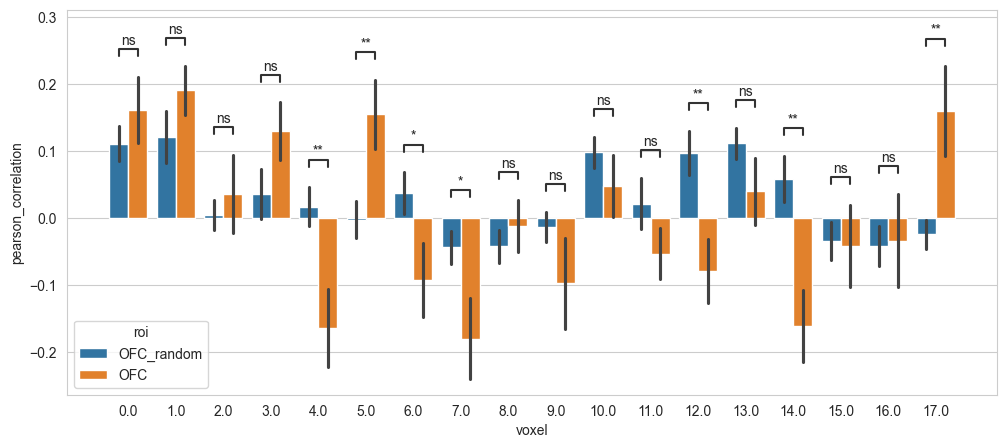

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_PirF_random vs. 9.0_PirF: t-test independent samples, P_val:3.945e-01 t=8.612e-01
10.0_PirF_random vs. 10.0_PirF: t-test independent samples, P_val:1.380e-05 t=-4.988e+00
11.0_PirF_random vs. 11.0_PirF: t-test independent samples, P_val:2.304e-02 t=2.369e+00
12.0_PirF_random vs. 12.0_PirF: t-test independent samples, P_val:1.149e-01 t=1.614e+00
13.0_PirF_random vs. 13.0_PirF: t-test independent samples, P_val:3.066e-03 t=3.163e+00
14.0_PirF_random vs. 14.0_PirF: t-test independent samples, P_val:8.669e-01 t=1.688e-01
15.0_PirF_random vs. 15.0_PirF: t-test independent samples, P_val:5.363e-02 t=-1.992e+00
16.0_PirF_random vs. 16.0_PirF: t-test independent samples, P_val:4.359e-02 t=-2.088e+00
17.0_PirF_random vs. 17.0_PirF: t-test independent samples, P_val:4.816e-03 t=-2.994e+00
8.0_PirF_rando

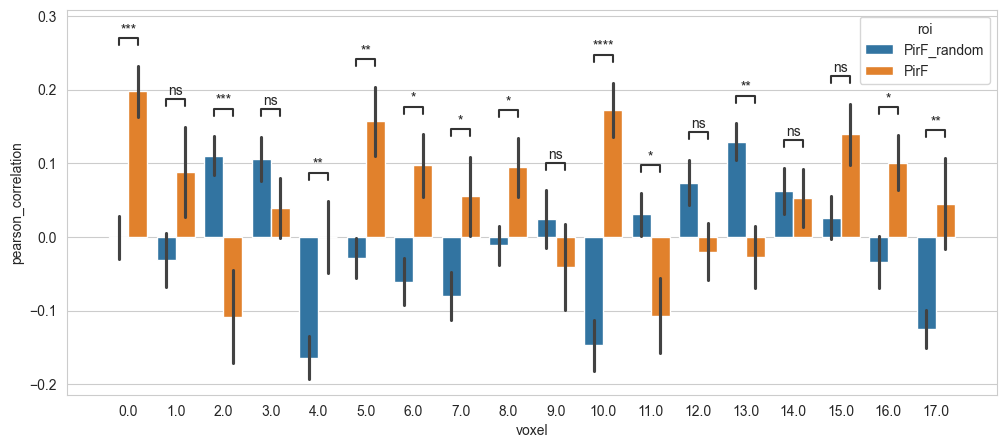

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_PirT_random vs. 9.0_PirT: t-test independent samples, P_val:3.047e-01 t=-1.041e+00
10.0_PirT_random vs. 10.0_PirT: t-test independent samples, P_val:1.367e-02 t=-2.586e+00
11.0_PirT_random vs. 11.0_PirT: t-test independent samples, P_val:3.298e-02 t=-2.213e+00
12.0_PirT_random vs. 12.0_PirT: t-test independent samples, P_val:1.422e-01 t=1.499e+00
13.0_PirT_random vs. 13.0_PirT: t-test independent samples, P_val:1.431e-05 t=-4.976e+00
14.0_PirT_random vs. 14.0_PirT: t-test independent samples, P_val:7.506e-02 t=1.830e+00
15.0_PirT_random vs. 15.0_PirT: t-test independent samples, P_val:5.363e-01 t=6.241e-01
16.0_PirT_random vs. 16.0_PirT: t-test independent samples, P_val:5.683e-02 t=-1.964e+00
17.0_PirT_random vs. 17.0_PirT: t-test independent samples, P_val:6.734e-01 t=4.248e-01
8.0_PirT_rand

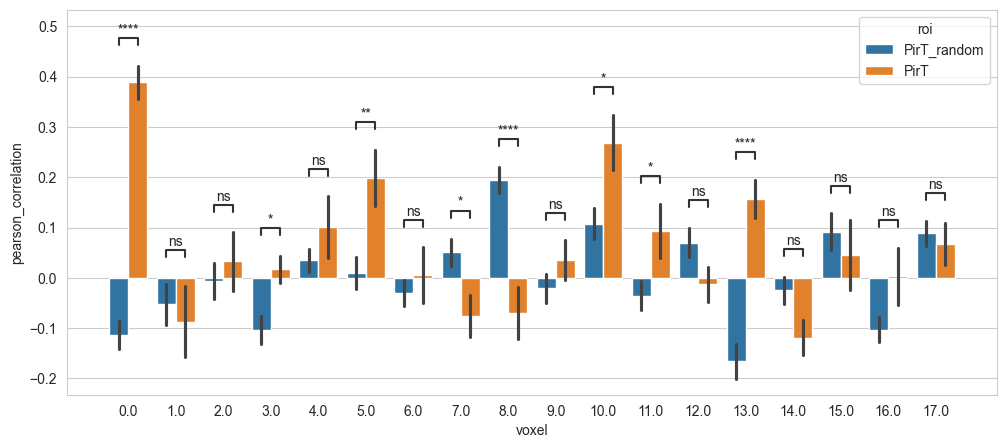

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_MolFormer vs. 9.0_MolFormer_random: t-test independent samples, P_val:1.055e-04 t=4.163e+00
10.0_MolFormer vs. 10.0_MolFormer_random: t-test independent samples, P_val:6.847e-01 t=-4.081e-01
11.0_MolFormer vs. 11.0_MolFormer_random: t-test independent samples, P_val:1.673e-02 t=-2.464e+00
12.0_MolFormer vs. 12.0_MolFormer_random: t-test independent samples, P_val:1.801e-04 t=-4.003e+00
13.0_MolFormer vs. 13.0_MolFormer_random: t-test independent samples, P_val:9.818e-01 t=2.291e-02
14.0_MolFormer vs. 14.0_MolFormer_random: t-test independent samples, P_val:1.747e-01 t=-1.374e+00
15.0_MolFormer vs. 15.0_MolFormer_random: t-test independent samples, P_val:3.732e-04 t=-3.779e+00
16.0_MolFormer vs. 16.0_MolFormer_random: t-test independent samples, P_val:1.782e-02 t=2.439e+00
17.0_MolFormer vs. 17

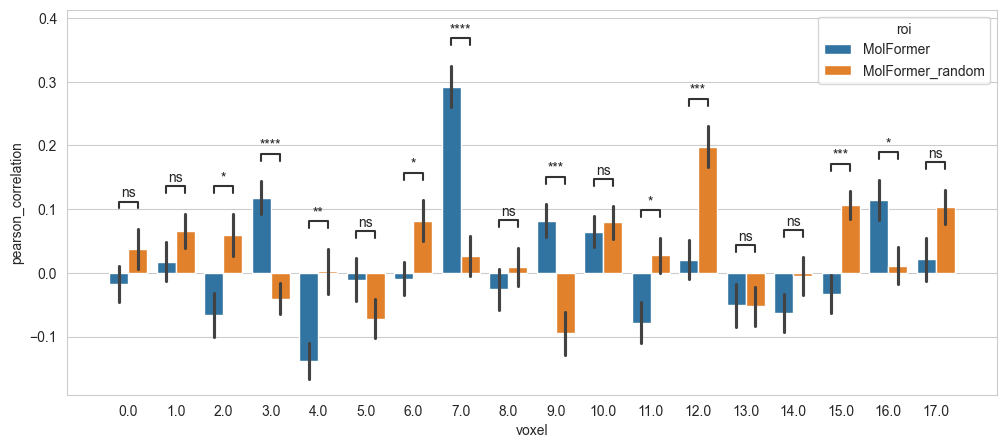

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_POM vs. 9.0_POM_random: t-test independent samples, P_val:3.721e-02 t=2.159e+00
10.0_POM vs. 10.0_POM_random: t-test independent samples, P_val:8.417e-06 t=5.146e+00
11.0_POM vs. 11.0_POM_random: t-test independent samples, P_val:8.331e-02 t=1.779e+00
12.0_POM vs. 12.0_POM_random: t-test independent samples, P_val:4.564e-04 t=3.837e+00
13.0_POM vs. 13.0_POM_random: t-test independent samples, P_val:1.848e-01 t=-1.351e+00
14.0_POM vs. 14.0_POM_random: t-test independent samples, P_val:8.769e-02 t=1.753e+00
15.0_POM vs. 15.0_POM_random: t-test independent samples, P_val:7.397e-02 t=1.837e+00
16.0_POM vs. 16.0_POM_random: t-test independent samples, P_val:9.151e-01 t=1.073e-01
17.0_POM vs. 17.0_POM_random: t-test independent samples, P_val:1.337e-02 t=2.595e+00
8.0_POM vs. 8.0_POM_random: t-test 

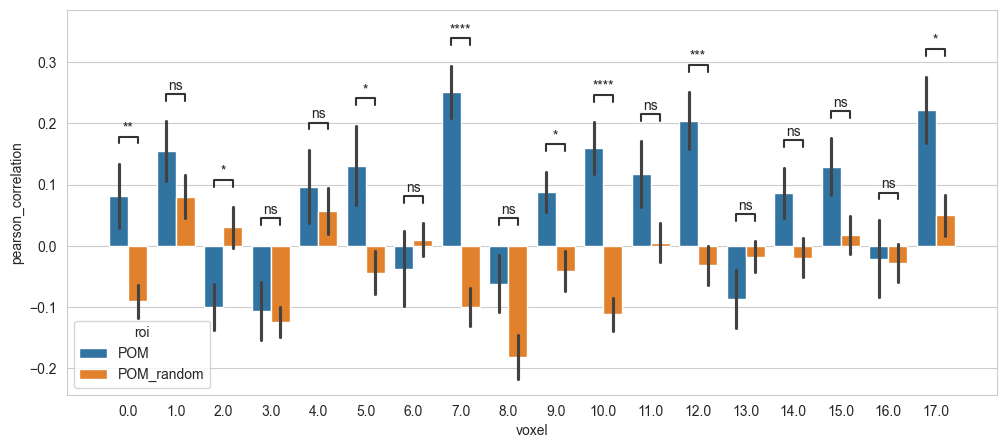

In [68]:
#barplot

for roi in ["AMY", "OFC" , "PirF" , "PirT", "MolFormer", "POM"]:
    plt.figure(figsize=(12, 5))
    df_metrics_all_avg_voxel_roi = df_metrics_all[(df_metrics_all['roi']==roi) |(df_metrics_all['roi']==roi+"_random") ]
    ax =sns.barplot(data=df_metrics_all_avg_voxel_roi, x='voxel', y='pearson_correlation', hue='roi',errorbar='se')
    pairs = [
    ((i, f"{roi}"), (i, f"{roi}_random"))
    for i in [float(x) for x in range(18)]]
    annotator = Annotator(ax, pairs, data=df_metrics_all_avg_voxel_roi, x='voxel', y='pearson_correlation', hue='roi')
    annotator.configure(test="t-test_ind", text_format="star", loc="inside",         # Places stars outside (on top of groups)
      )
    annotator.apply_and_annotate()
    plt.show()


In [32]:
from statannotations.Annotator import Annotator

In [37]:
df_metrics_all

pearson_correlation  pearson_pvalue       mse  voxel  \
0              -0.261593        0.148110  0.317084    0.0   
1              -0.098215        0.592804  0.138007    1.0   
2              -0.012785        0.944631  0.168112    2.0   
3              -0.329823        0.065256  0.249574    3.0   
4               0.126521        0.490184  0.180267    4.0   
..                   ...             ...       ...    ...   
535            -0.098499        0.591728  0.247967   13.0   
536             0.223687        0.218440  0.172945   14.0   
537             0.110717        0.546343  0.105041   15.0   
538             0.084613        0.645211  0.174736   16.0   
539             0.053099        0.772866  0.201677   17.0   

     spearman_correlation  spearman_pvalue   run  subject         roi  \
0               -0.216662         0.233624   0.0        1  AMY_random   
1               -0.072784         0.692199   0.0        1  AMY_random   
2               -0.068388         0.709963   0.0        1  AMY_random   
3               -0.323152         0.071224   0.0        1  AMY_random   
4                0.171619         0.347631   0.0        1  AMY_random   
..                    ...              ...   ...      ...         ...   
535             -0.086237         0.638858  29.0        1  POM_random   
536              0.206780         0.256162  29.0        1  POM_random   
537             -0.047825         0.794924  29.0        1  POM_random   
538             -0.019162         0.917096  29.0        1  POM_random   
539              0.001474         0.993612  29.0        1  POM_random   

        nrmse  
0    0.281551  
1    0.185746  
2    0.205007  
3    0.249787  
4    0.212289  
..        ...  
535  0.248982  
536  0.207933  
537  0.162050  
538  0.209007  
539  0.224542  

[4680 rows x 10 columns]

In [69]:
df_metrics_all['nrmse'] = (np.sqrt(df_metrics_all['mse']))/(2)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_AMY_random vs. 9.0_AMY: t-test independent samples, P_val:3.975e-01 t=8.557e-01
10.0_AMY_random vs. 10.0_AMY: t-test independent samples, P_val:9.824e-02 t=1.695e+00
11.0_AMY_random vs. 11.0_AMY: t-test independent samples, P_val:7.453e-01 t=-3.272e-01
12.0_AMY_random vs. 12.0_AMY: t-test independent samples, P_val:6.460e-01 t=4.630e-01
13.0_AMY_random vs. 13.0_AMY: t-test independent samples, P_val:9.873e-01 t=-1.609e-02
14.0_AMY_random vs. 14.0_AMY: t-test independent samples, P_val:7.858e-01 t=-2.737e-01
15.0_AMY_random vs. 15.0_AMY: t-test independent samples, P_val:8.485e-01 t=1.923e-01
16.0_AMY_random vs. 16.0_AMY: t-test independent samples, P_val:6.702e-01 t=4.292e-01
17.0_AMY_random vs. 17.0_AMY: t-test independent samples, P_val:1.037e-01 t=1.667e+00
8.0_AMY_random vs. 8.0_AMY: t-tes

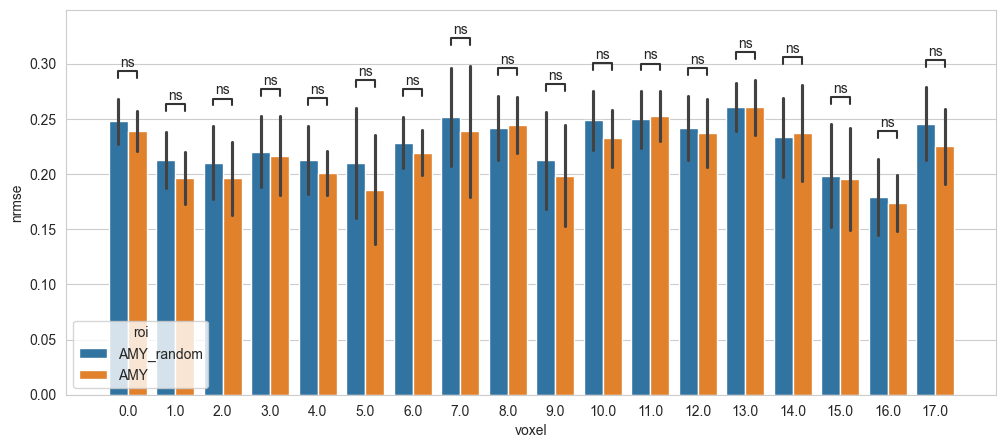

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_OFC_random vs. 9.0_OFC: t-test independent samples, P_val:4.129e-01 t=8.279e-01
10.0_OFC_random vs. 10.0_OFC: t-test independent samples, P_val:2.571e-01 t=1.151e+00
11.0_OFC_random vs. 11.0_OFC: t-test independent samples, P_val:8.019e-01 t=-2.526e-01
12.0_OFC_random vs. 12.0_OFC: t-test independent samples, P_val:6.868e-01 t=4.064e-01
13.0_OFC_random vs. 13.0_OFC: t-test independent samples, P_val:6.446e-01 t=-4.649e-01
14.0_OFC_random vs. 14.0_OFC: t-test independent samples, P_val:8.113e-01 t=-2.404e-01
15.0_OFC_random vs. 15.0_OFC: t-test independent samples, P_val:8.173e-01 t=2.326e-01
16.0_OFC_random vs. 16.0_OFC: t-test independent samples, P_val:5.472e-01 t=6.073e-01
17.0_OFC_random vs. 17.0_OFC: t-test independent samples, P_val:6.437e-02 t=1.905e+00
8.0_OFC_random vs. 8.0_OFC: t-tes

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_PirF_random vs. 9.0_PirF: t-test independent samples, P_val:4.582e-01 t=7.495e-01
10.0_PirF_random vs. 10.0_PirF: t-test independent samples, P_val:9.403e-02 t=1.718e+00
11.0_PirF_random vs. 11.0_PirF: t-test independent samples, P_val:6.370e-01 t=-4.757e-01
12.0_PirF_random vs. 12.0_PirF: t-test independent samples, P_val:6.503e-01 t=4.569e-01
13.0_PirF_random vs. 13.0_PirF: t-test independent samples, P_val:5.571e-01 t=-5.924e-01
14.0_PirF_random vs. 14.0_PirF: t-test independent samples, P_val:8.803e-01 t=-1.517e-01
15.0_PirF_random vs. 15.0_PirF: t-test independent samples, P_val:7.730e-01 t=2.905e-01
16.0_PirF_random vs. 16.0_PirF: t-test independent samples, P_val:5.215e-01 t=6.471e-01
17.0_PirF_random vs. 17.0_PirF: t-test independent samples, P_val:7.387e-02 t=1.838e+00
8.0_PirF_random

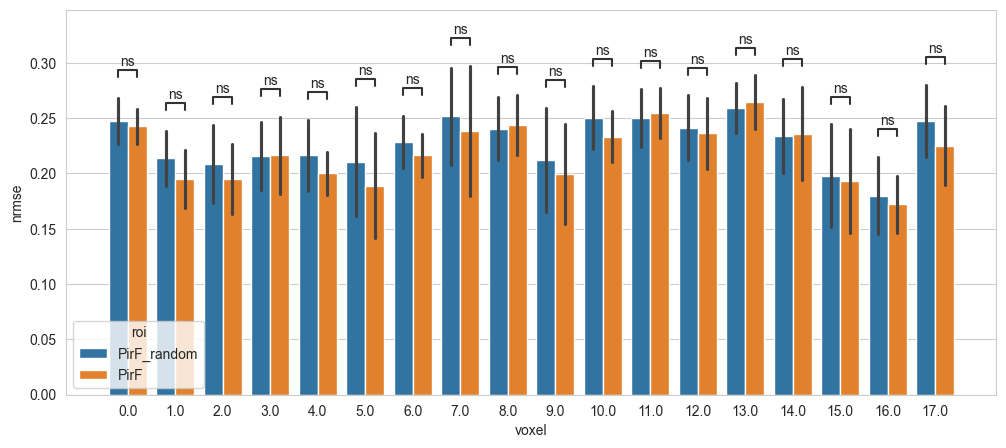

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_PirT_random vs. 9.0_PirT: t-test independent samples, P_val:3.956e-01 t=8.592e-01
10.0_PirT_random vs. 10.0_PirT: t-test independent samples, P_val:1.001e-01 t=1.686e+00
11.0_PirT_random vs. 11.0_PirT: t-test independent samples, P_val:9.607e-01 t=4.955e-02
12.0_PirT_random vs. 12.0_PirT: t-test independent samples, P_val:7.892e-01 t=2.692e-01
13.0_PirT_random vs. 13.0_PirT: t-test independent samples, P_val:9.409e-01 t=7.463e-02
14.0_PirT_random vs. 14.0_PirT: t-test independent samples, P_val:8.676e-01 t=-1.679e-01
15.0_PirT_random vs. 15.0_PirT: t-test independent samples, P_val:8.615e-01 t=1.757e-01
16.0_PirT_random vs. 16.0_PirT: t-test independent samples, P_val:4.799e-01 t=7.135e-01
17.0_PirT_random vs. 17.0_PirT: t-test independent samples, P_val:1.288e-01 t=1.553e+00
8.0_PirT_random v

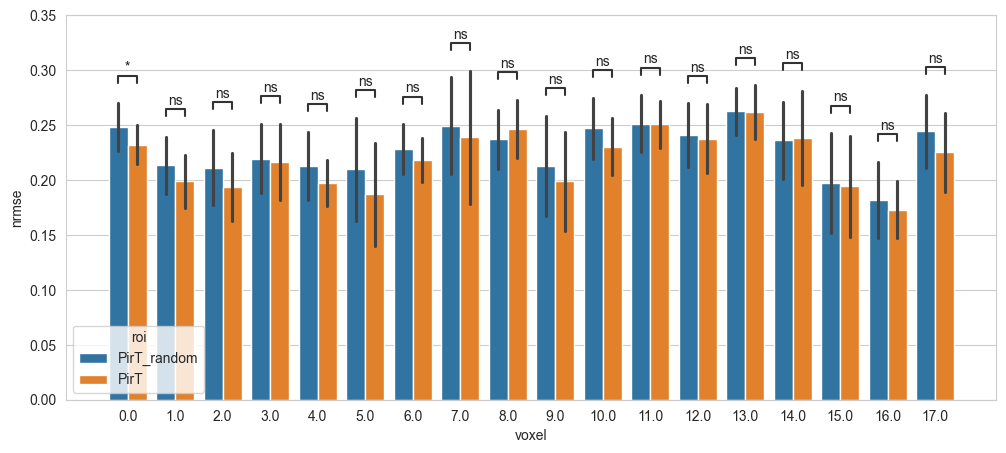

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_MolFormer vs. 9.0_MolFormer_random: t-test independent samples, P_val:7.813e-01 t=-2.789e-01
10.0_MolFormer vs. 10.0_MolFormer_random: t-test independent samples, P_val:9.657e-01 t=4.319e-02
11.0_MolFormer vs. 11.0_MolFormer_random: t-test independent samples, P_val:8.994e-01 t=1.270e-01
12.0_MolFormer vs. 12.0_MolFormer_random: t-test independent samples, P_val:6.857e-01 t=4.067e-01
13.0_MolFormer vs. 13.0_MolFormer_random: t-test independent samples, P_val:9.151e-01 t=-1.071e-01
14.0_MolFormer vs. 14.0_MolFormer_random: t-test independent samples, P_val:9.688e-01 t=-3.929e-02
15.0_MolFormer vs. 15.0_MolFormer_random: t-test independent samples, P_val:9.521e-01 t=6.028e-02
16.0_MolFormer vs. 16.0_MolFormer_random: t-test independent samples, P_val:8.339e-01 t=-2.106e-01
17.0_MolFormer vs. 17.

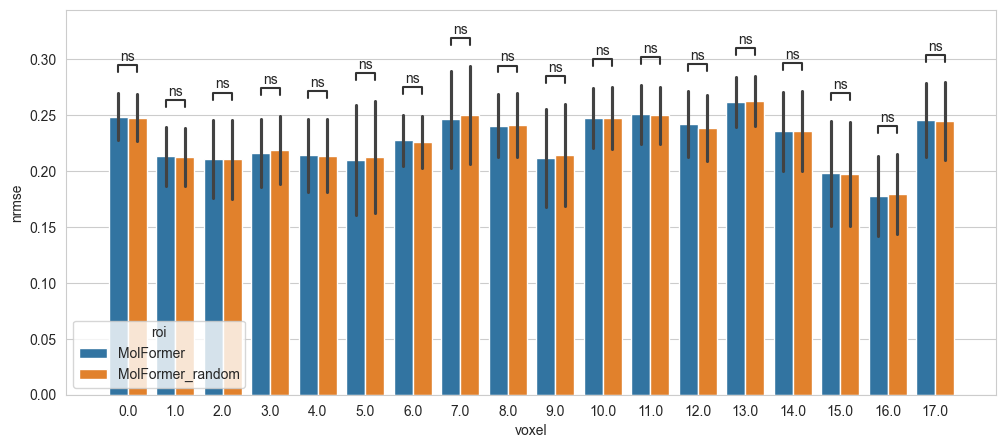

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9.0_POM vs. 9.0_POM_random: t-test independent samples, P_val:3.394e-01 t=-9.675e-01
10.0_POM vs. 10.0_POM_random: t-test independent samples, P_val:1.205e-01 t=-1.588e+00
11.0_POM vs. 11.0_POM_random: t-test independent samples, P_val:9.428e-01 t=7.222e-02
12.0_POM vs. 12.0_POM_random: t-test independent samples, P_val:4.482e-01 t=-7.663e-01
13.0_POM vs. 13.0_POM_random: t-test independent samples, P_val:6.867e-01 t=4.064e-01
14.0_POM vs. 14.0_POM_random: t-test independent samples, P_val:9.949e-01 t=-6.445e-03
15.0_POM vs. 15.0_POM_random: t-test independent samples, P_val:7.975e-01 t=-2.584e-01
16.0_POM vs. 16.0_POM_random: t-test independent samples, P_val:6.103e-01 t=-5.139e-01
17.0_POM vs. 17.0_POM_random: t-test independent samples, P_val:8.642e-02 t=-1.760e+00
8.0_POM vs. 8.0_POM_random: t

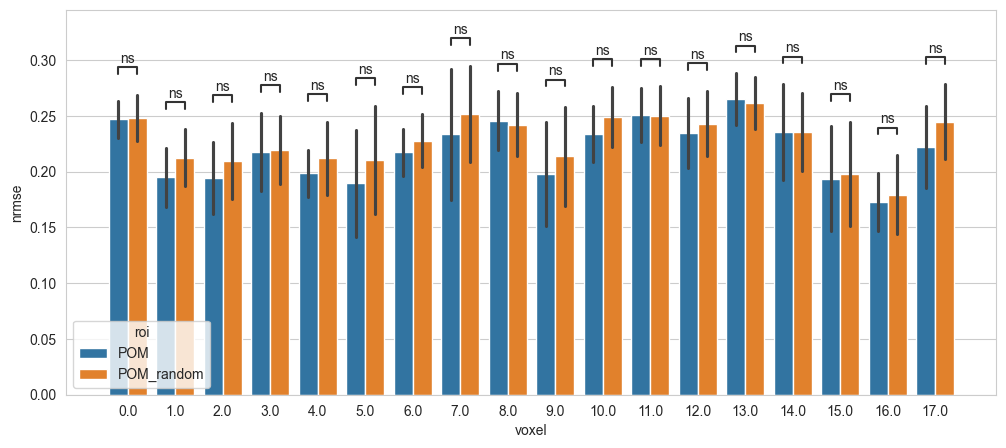

In [70]:
for roi in ["AMY", "OFC" , "PirF" , "PirT", "MolFormer", "POM"]:
    plt.figure(figsize=(12, 5))
    df_metrics_all_avg_voxel_roi = df_metrics_all[(df_metrics_all['roi']==roi) |(df_metrics_all['roi']==roi+"_random") ]
    ax = sns.barplot(data=df_metrics_all_avg_voxel_roi, x='voxel', y='nrmse', hue='roi',errorbar='sd')
    pairs = [
    ((i, f"{roi}"), (i, f"{roi}_random"))
    for i in [float(x) for x in range(18)]]
    annotator = Annotator(ax, pairs, data=df_metrics_all_avg_voxel_roi, x='voxel', y='nrmse', hue='roi')
    annotator.configure(test="t-test_ind", text_format="star", loc="inside",         # Places stars outside (on top of groups)
      )
    annotator.apply_and_annotate()

    plt.show()

<Axes: xlabel='pearson_correlation', ylabel='Count'>

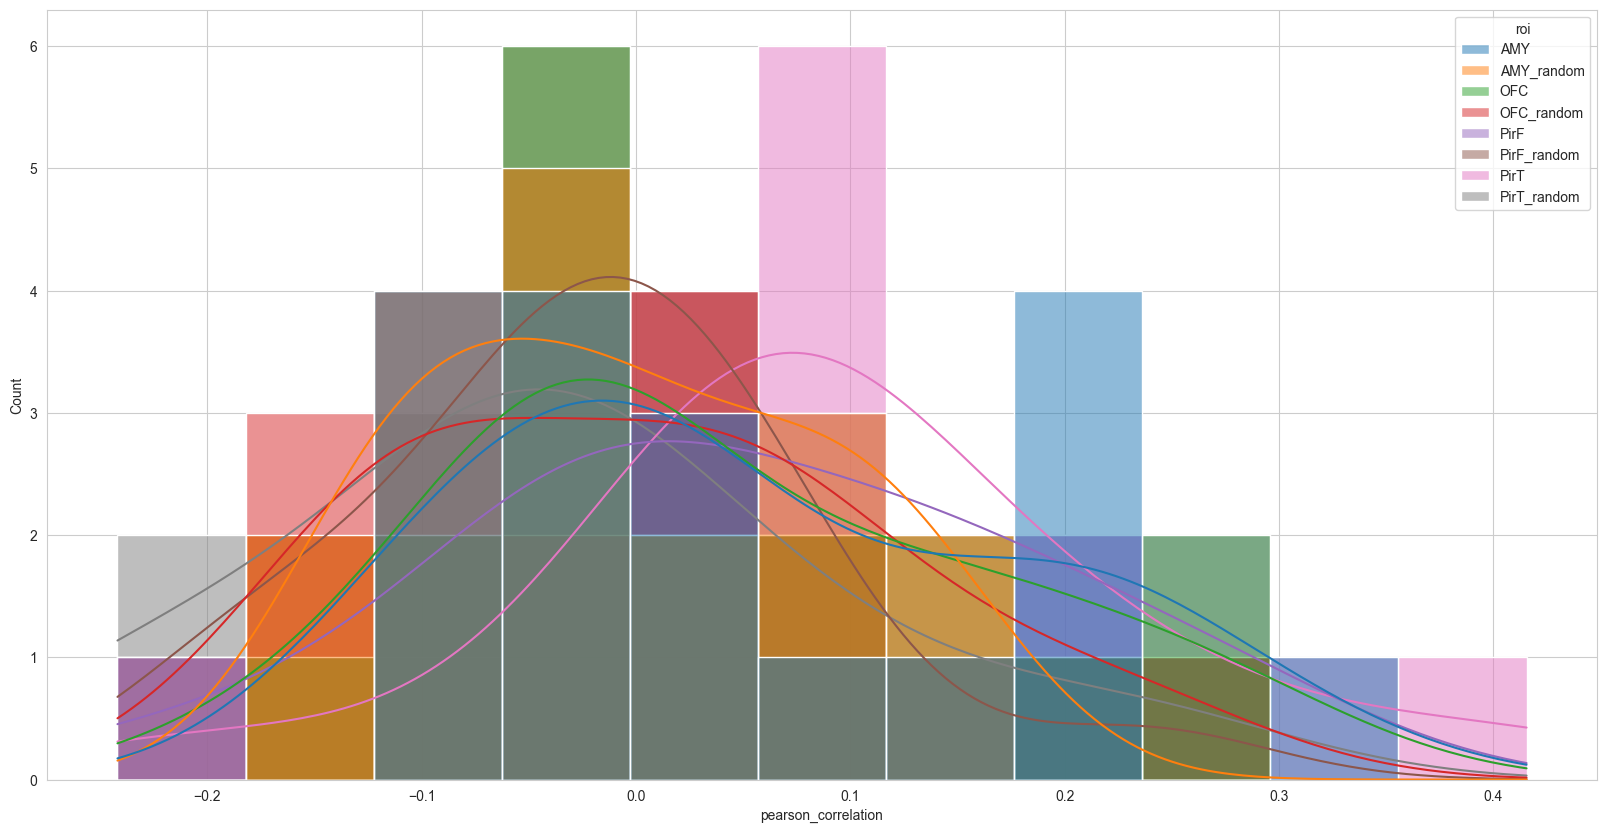

In [68]:
fig,ax= plt.subplots(figsize=(20,10))
sns.histplot(data=df_metrics_all_avg_voxel,x='pearson_correlation',hue='roi',ax=ax,kde=True)

In [17]:
from scipy.stats import ttest_rel
for roi in ["AMY", "OFC" , "PirF" , "PirT"]:
    df_metrics_all_avg_voxel_roi = df_metrics_all_avg_voxel[(df_metrics_all_avg_voxel['roi']==roi) |(df_metrics_all_avg_voxel['roi']==roi+"_random") ]
    # Reshape data to have one column per group (wide format)
    wide_df = df_metrics_all_avg_voxel_roi.pivot(index='voxel', columns='roi', values='rmse')

# Perform a paired t-test
    t_stat, p_value = ttest_rel(wide_df[roi], wide_df[roi+"_random"])
    print(p_value)

0.03337424866110955
0.05014404175111691
0.04747519828708891
0.000533693308717188


In [74]:
wide_df

roi        PirT  PirT_random
voxel                       
0.0    0.415515    -0.082403
1.0    0.050199    -0.041493
2.0    0.084236    -0.140072
3.0    0.068899    -0.026053
4.0    0.299746    -0.103032
5.0    0.170560    -0.174400
6.0    0.072242    -0.035809
7.0   -0.208680    -0.046680
8.0   -0.068494    -0.085390
9.0    0.061792     0.098444
10.0   0.209554     0.074095
11.0   0.061543    -0.022701
12.0   0.004177     0.004198
13.0   0.188987     0.254525
14.0   0.097713    -0.241874
15.0   0.131544     0.189112
16.0   0.023221     0.035773
17.0   0.044209    -0.237161

In [69]:
fig,ax= plt.subplots(figsize=(20,10))

sns.barplot(data=df_metrics_all_avg_voxel,x='roi',y='mse',ax=ax)

<Axes: xlabel='roi', ylabel='mse'>

#

In [114]:
fig,ax= plt.subplots(figsize=(20,10))
sns.barplot(data=df_metrics_all,x='roi',y='pearson_correlation',ax=ax)

<Axes: xlabel='roi', ylabel='pearson_correlation'>

In [ ]:
df_metrics_all = pd.DataFrame()
for roi in ['AMY','OFC','PirF','PirT']:
    X=np.load(f"data/subject1/fMRI/{roi}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
    df_predictions, df_metric = compute_correlation(X,y,n_components=None,model='MLP')

    df_metric['roi'] = roi
    X_random = np.random.rand(X.shape[0],X.shape[1])
    df_predictions_random , df_metric_random = compute_correlation(X_random,y,n_components=None)

    df_metric_random['roi'] = roi+'_random'
    df_metrics_all = pd.concat([df_metrics_all,df_metric_random])
    df_metrics_all = pd.concat([df_metrics_all,df_metric])